In [2]:
import warnings; warnings.simplefilter('ignore')
import os
import sys
import time
import math
import shutil
import pickle
import random
import anndata
import operator
import matplotlib
import pylab as pl
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
from scipy import sparse
from matplotlib import cm
from fish_helpers import *
from IPython import display
import tqdm#.notebook as tqdm
from scipy.stats import mode
from functools import partial
from segmentation_3D import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib._color_data as mcd
import scipy.cluster.hierarchy as shc
from scipy.interpolate import interp1d
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics.pairwise import euclidean_distances
base = '/bigstore/binfo/mouse/Hippocampus/'

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
A = [
    "A",
"A",
"B+",
"A",
"A",
"C+",
"B",
"A-",
"A",
"A",
"A",
"A",
"B+",
"A",
"A",
"A-",
"A-",
"B+",
"A-",
"B+",
"A-",
"A",
"A",
"B+",
"A-",
"A",
"A",
"A",
"A",
"A",
"A",
"A-",
"A",
"B+",
"A-",
"A",
"A-",
"A-",
"A",
"A",
"A",
"A",
"A",
"A-",
"A-",
"A",
"A",
"A",
"B-",
"A",
"A",
]
Counter(A)

Counter({'A': 30, 'B+': 6, 'C+': 1, 'B': 1, 'A-': 12, 'B-': 1})

In [5]:
len(A)

51

In [2]:
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
sample_cluster_probabilities = pd.read_csv(os.path.join(base,'sample_cluster_probabilities.csv'),index_col=0)
cells = list(metadata.index)
prob = sample_cluster_probabilities.loc[cells]

In [3]:
MM = pd.read_csv('/home/rwollman/MyProjects/CSI/MeasurementMatrixPCA24.csv',index_col=0).T
Imputed = pd.read_csv('/home/rwollman/MyProjects/CSI/PredictionNB24bits.csv',index_col=0)
Imputed

,sample_name,prediction,true.label
1,LS-14690_S02_E1-50,Pvalb_8,Pvalb_8
2,LS-14690_S03_E1-50,L4 IT_3,L4 IT_3
3,LS-14690_S05_E1-50,L4 IT_3,L4 IT_3
4,LS-14690_S06_E1-50,L4 IT_3,L4 IT_3
5,LS-14690_S07_E1-50,L4 IT_3,L4 IT_3
6,LS-14690_S08_E1-50,L4 IT_3,L4 IT_3
7,LS-14690_S09_E1-50,L4 IT_3,L4 IT_3
8,LS-14690_S10_E1-50,Vip_9,Vip_9
9,LS-14690_S11_E1-50,L2/3 IT Otof_5,L2/3 IT Otof_5
10,LS-14690_S12_E1-50,L4 IT_3,L4 IT_3


In [34]:
MM

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
X1110008P14Rik,1,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
X1500009L16Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1500011B03Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700001L19Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700019D03Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700037H04Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700086L19Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1810037I17Rik,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X2010300C02Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X2210013O21Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
"""
Load seperability filtered counts
"""
filtered_counts_sparse = sparse.load_npz(os.path.join(base,'Allen/seperability_filtered_counts.npz'))
filtered_counts = filtered_counts_sparse.A
cells = list(pd.read_csv(os.path.join(base,'Allen/seperability_filtered_cells.csv'),index_col=0)['0'])
filtered_genes = list(pd.read_csv(os.path.join(base,'Allen/seperability_filtered_genes.csv'),index_col=0)['0'])

In [40]:
shared_genes = list(set(list(MM.index)).intersection(filtered_genes))
filtered_counts_df = pd.DataFrame(filtered_counts,index=filtered_genes,columns=cells)
filtered_counts_df=filtered_counts_df.loc[shared_genes]

In [6]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

C = []
H = []
A = []
B = []
node_dict = {}

node = data
c,h,a,b,children = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
print(len(C))
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1

579


In [7]:
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in tqdm.tqdm(enumerate(cells),total=ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types).T

100%|██████████| 290/290 [00:14<00:00, 20.64it/s]


In [8]:
node_matrix = np.zeros((len(cells),len(binary_node_df.index)))
for cell_type in tqdm.tqdm(good_types):
    cell_type_cells = list(metadata[metadata['cell_type_alias_label']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(cells))
    cell_type_node = np.array(binary_node_df[cell_type])
    node_matrix[np.where(np.isin(cells,cell_type_cells)),:] = cell_type_node
node_df = pd.DataFrame(node_matrix,index=cells,columns=binary_node_df.index)

100%|██████████| 290/290 [00:24<00:00, 12.06it/s]


In [9]:
"""
Metric for dendrogram accuracy
sum of (weights+1 * accuracy)/ncells 
weights = node by weight df linkage['H']
ncells = node by ncells df from node_df
could be same df
"""
temp = linkage
temp.index = temp['C']
node_metrics = pd.DataFrame(index=node_df.columns)
node_metrics['weights'] = 1+pd.DataFrame(temp['H'])
node_metrics['ncells'] = pd.DataFrame(node_df.sum())
node_metrics

,weights,ncells
n1,1.8416,74967.0
n2,1.6271,74101.0
n281,1.7175,866.0
n3,1.3650,72893.0
n274,1.5365,1208.0
n283,1.5418,681.0
n282,1.2631,185.0
n4,1.2512,72854.0
CR,1.0000,39.0
n277,1.4810,1057.0


In [41]:
"""
Filtered CSI matrix format
"""
matrix_df = filtered_counts_df#pd.DataFrame(filtered_counts,index=filtered_genes,columns=cells)
# matrix_df = matrix_df.loc[MM.index] #Puts everthing in same order
# avg = np.median(filtered_counts,axis=1)
# std = np.std(filtered_counts,axis=1)
# zscore = pd.DataFrame(filtered_counts-avg[:,None]/std[:,None],index=filtered_genes,columns=cells)
info_df = metadata.loc[cells]
info_df['cell_type'] = info_df['cell_type_alias_label']
info_df

,cluster_color,cluster_order,cluster_label,class_color,class_order,class_label,subclass_color,subclass_order,subclass_label,full_genotype_color,...,injection_roi_color,injection_roi_order,injection_roi_label,propagation_type_color,propagation_type_order,propagation_type_label,subregion_color,subregion_order,subregion_label,cell_type
sample_name,,,,,,,,,,,,,,,,,,,,,
LS-14690_S02_E1-50,#8C2A27,84,Pvalb_8,#FF9F2C,1,GABAergic,#D93137,9,Pvalb,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,Pvalb_8
LS-14690_S03_E1-50,#3ECD7D,155,L4 IT_3,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_3
LS-14690_S05_E1-50,#3ECD7D,155,L4 IT_3,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_3
LS-14690_S06_E1-50,#3ECD7D,155,L4 IT_3,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_3
LS-14690_S07_E1-50,#3ECD7D,155,L4 IT_3,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_3
LS-14690_S08_E1-50,#3ECD7D,155,L4 IT_3,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_3
LS-14690_S09_E1-50,#3ECD7D,155,L4 IT_3,#0078C3,2,Glutamatergic,#00E297,22,L4 IT,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L4 IT_3
LS-14690_S10_E1-50,#9256A6,37,Vip_9,#FF9F2C,1,GABAergic,#B864CC,6,Vip,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,Vip_9
LS-14690_S11_E1-50,#21D238,129,L2/3 IT Otof_5,#0078C3,2,Glutamatergic,#0BE652,19,L2/3 IT Otof,#700099,...,#FF7373,1,NaN,#FF7373,1,NaN,#FF7373,1,NaN,L2/3 IT Otof_5


In [16]:
matrix_df.head()

,SM-GE669_S180_E1-50,SQ-80015_S33_E1-50,SM-GE93C_S038_E1-50,SM-GE8Z8_S370_E1-50,SM-GE5TP_S167_E1-50,SM-GE679_S037_E1-50,SM-D9D91_S64_E1-50,SM-DAIFW_S61_E1-50,SM-GE63V_S055_E1-50,US-1250273_E2_S75,...,LS-15310_S29_E2-50,LS-15514_S45_E1-50,SM-GE5P2_S093_E1-50,SM-DAIHD_S06_E1-50,SM-GE91L_S292_E1-50,SM-GE65P_S312_E1-50,SM-GE8Z8_S102_E1-50,SM-GE8Y3_S312_E1-50,SM-D9EPQ_S77_E1-50,SM-D9E5T_S40_E1-50
1110008P14Rik,224.541012,355.954290,131.097971,795.095757,28.866400,55.693477,0.0,440.453138,419.323888,430.675858,...,39.816092,865.803910,946.830539,437.132494,1327.836858,106.373313,572.383251,86.070995,111.923072,778.862243
1500009L16Rik,0.000000,33.255245,236.657376,47.738669,105.277457,0.000000,0.0,0.000000,448.180585,47.742358,...,29.338173,106.357638,31.728007,55.287443,0.000000,130.750530,20.442259,106.456231,72.283650,0.000000
1500011B03Rik,347.818430,153.959468,301.355076,302.893622,242.817361,482.676797,0.0,229.801637,321.030761,177.044579,...,287.094976,334.894710,175.338989,294.521893,193.602134,436.573804,217.431300,287.658325,436.033633,302.766461
1700001L19Rik,0.000000,53.783174,0.000000,118.523591,20.376282,0.000000,0.0,18.176401,45.088590,21.384598,...,0.000000,59.771234,10.019371,36.686060,31.289234,0.000000,159.821297,0.000000,11.658653,72.556460
1700019D03Rik,17.611060,42.287534,0.000000,0.000000,0.000000,25.315217,0.0,0.000000,0.000000,79.570597,...,46.102843,16.700786,0.000000,15.501152,17.600194,53.186656,39.026131,0.000000,81.610573,85.097082


In [42]:
base_path = '/bigstore/GeneralStorage/Zach/CSI/Allen_CSI/'
if not os.path.exists(base_path):
    os.mkdir(base_path)
class CompressedSensingClass(object):
    def __init__(self,matrix,
                 info_df=[],
                 node_df=[],
                 node_metrics=[],
                 avg=[],
                 std=[],
                 zscore=[],
                 which_genes=[],
                 subsample=1000,
                 noise = 0.1,
                 metric='cell_type',
                 nblanks=None,
                 npos=1000,
                 nbits=18,
                 ncpu=1,
                 pop_ncpu=1,
                 keepers=10,
                 mutation_rate=0.1,
                 offspring_number=0,
                 mutation_number=0,
                 k=100,
                 sample=1000,
                 survivors=[],
                 iterations=100,
                 base_path='',
                 color='r',
                 fresh=True,
                 verbose=True):
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)
            
        matrix = matrix.astype('int16')
        self.node_df = node_df
        self.node_metrics = node_metrics
        self.noise = noise
        self.metric = metric
        self.info_df = info_df
        self.cell_types = self.info_df.cell_type.unique()
        self.fresh = fresh
        self.verbose = verbose
        self.zscore = zscore
        self.std = std
        self.avg = avg
        self.cells = list(matrix.columns)
        self.ncells = len(self.cells)
        self.full_matrix = matrix
        if nblanks==None:
            nblanks = npos
        if nblanks>0:
            blanks = pd.DataFrame(np.zeros((nblanks,self.ncells)),index=['blank'+str(i)for i in range(nblanks)],columns=self.cells)
            if len(which_genes)==0:
                self.matrix = pd.concat([matrix,blanks])
            else:
                self.matrix = pd.concat([matrix.loc[which_genes],blanks])
        else:
            if len(which_genes)==0:
                self.matrix = matrix
            else:
                self.matrix = matrix.loc[which_genes]
        self.nblanks = nblanks
        self.genes = list(self.matrix.index)
        self.ngenes = len(self.genes)
        self.npos = npos
        self.nbits = nbits
        self.ncpu = ncpu
        self.pop_ncpu = pop_ncpu
        self.keepers = keepers
        self.ideal = np.zeros(self.ngenes)
        self.ideal[0:npos] = 1
        self.ideal = list(self.ideal)
        self.mutation_rate = mutation_rate
        self.offspring_number = offspring_number
        self.mutation_number = mutation_number
        self.k = k # could infer
        self.sample = sample
        self.survivors = survivors
        self.iterations = iterations
        self.color = color
        if self.metric =='imputation':
            if len(zscore)==0:
                raise NameError('for imputation you need a zscore')
        elif self.metric == 'cell_type':
            if len(info_df)==0:
                raise NameError('for cell_type you need a info_df')
        elif self.metric == 'dendrogram':
            if len(info_df)==0:
                raise NameError('for dendrogram you need a info_df')
            if len(node_df)==0:
                raise NameError('for dendrogram you need a node_df')
            if len(node_metrics)==0:
                raise NameError('for dendrogram you need a node_metrics')
        else:
            print(self.metric)
            raise NameError(self.metric,'Is not a possible type')

    def generate_random(self):
        species = np.zeros((self.ngenes,self.nbits))
        mutable = int(self.npos)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        species[x,y] = 1
        return species

    def generate_starting_survivors(self):
        survivors = []
        for k in range(self.keepers):
            survivors.append(self.generate_random())
        self.survivors = survivors

    def generate_mutations(self,species):
        mutated = species.copy()
        possible_mutations = self.generate_random()
        mutable = int(random.random()*self.mutation_rate*self.ngenes*self.nbits)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        mutated[x,y] = possible_mutations[x,y]
        return mutated

    def generate_offspring(self,species,mate):
        offspring = species.copy()
        mutable = int(0.5*self.ngenes*self.nbits)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        offspring[x,y] = mate[x,y]
        return offspring

    def generate_progenerators(self):
        progenerators = self.survivors.copy()
        for species in self.survivors:
            for i in range(self.offspring_number):
                mate = self.survivors[random.randint(0,self.keepers-1)].copy()
                progenerators.append(self.generate_offspring(species,mate))
        self.progenerators = progenerators

    def pfunc_generate_mutations(self,species):
        ppopulation = []
        for i in range(self.mutation_number):
            ppopulation.append(self.generate_mutations(species))
        return ppopulation

    def generate_population(self):
        population = self.progenerators.copy()
        if self.mutation_number>0:
            if self.pop_ncpu==1:
                for species in self.progenerators:
                    for i in range(self.mutation_number):
                        population.append(self.generate_mutations(species))
            else:
                sys.stdout.flush()
                with Pool(self.pop_ncpu) as p:
                    for ppopulation in p.imap(self.pfunc_generate_mutations,self.progenerators,chunksize=1):
                        for species in ppopulation:
                            population.append(species)
                sys.stdout.flush()
        self.population = population

    def generate_compressed(self,species):
        compressed = pd.DataFrame(index=self.cells)
        temp_matrix = np.array(self.matrix)
        out = []
        for i in range(self.nbits):
            compressed[i] = np.sum(np.multiply(temp_matrix,species[:,i][...,None]),axis=0)
        return compressed
    
    def imputation_metric(self,n,rank):
        cells = np.array(self.cells)
        metrics = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            zsig = self.zscore[cell]
            znn = np.average(self.zscore[knn],axis=1)
            metric = spearmanr(zsig,znn)[0]
            metrics.append(metric)
        metric = np.average(metrics)
        return metric
    
    def cell_type_metric(self,n,rank):
        cells = np.array(self.cells)
        metrics = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            cell = self.info_df.loc[cell].cell_type
            temp_df = self.info_df.loc[knn]
            metric = len(temp_df[temp_df.cell_type==cell])/self.k
            metrics.append(metric)
        metric = np.average(metrics)
        return metric

    def calculate_accuracy_dendrogram(self,truth,imputed):
        accuracy_matrix = np.zeros(len(imputed.columns))
        for i,node in enumerate(imputed.columns):
            imputed_cells = list(imputed[imputed[node]==1].index)
            truth_cells = list(truth[truth[node]==1].index)
            true = len(set(imputed_cells).intersection(truth_cells))
            ltruth = len(truth_cells)
            if ltruth>0:
                accuracy_matrix[i] = true/ltruth
            else:
                accuracy_matrix[i] = 0
        return accuracy_matrix
    
    def calculate_node_accuracy(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        test_cells = cells[n]
        noise = np.random.randn(len(n),self.nbits)
        sim = X[n,:]+(self.noise*X[n,:]*noise)
        dist = euclidean_distances(X, sim)
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        test_cells = cells[n]
        imputed_node_df = pd.DataFrame(index=test_cells,columns=self.node_df.columns)
        nn_cells = cells[rank[1,:]]
        temp = self.node_df.loc[nn_cells]
        temp.index = test_cells
        imputed_node_df.loc[test_cells] = temp
        truth_node_df = self.node_df.loc[test_cells]
        accuracy_matrix = self.calculate_accuracy_dendrogram(truth_node_df,imputed_node_df)
        return accuracy_matrix
    
    def dendrogram_metric(self,n,rank):
        cells = np.array(self.cells)
        test_cells = cells[n]
        imputed_node_df = pd.DataFrame(index=test_cells,columns=self.node_df.columns)
        nn_cells = cells[rank[1,:]]
        temp = self.node_df.loc[nn_cells]
        temp.index = test_cells
        imputed_node_df.loc[test_cells] = temp
        truth_node_df = self.node_df.loc[test_cells]
        accuracy_matrix = self.calculate_accuracy_dendrogram(truth_node_df,imputed_node_df)
        accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=imputed_node_df.columns,columns=['accuracy'])
        accuracy_matrix_df = pd.concat([accuracy_matrix_df,self.node_metrics],axis=1)
#         metric = np.sum(accuracy_matrix_df['accuracy']*accuracy_matrix_df['weights']*accuracy_matrix_df['ncells'])
        metric = np.sum(accuracy_matrix_df['accuracy']/accuracy_matrix_df['ncells'])
        return metric
    
    def calculate_metric(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        test_cells = cells[n]
        noise = np.random.randn(len(n),self.nbits)
        sim = X[n,:]+(self.noise*X[n,:]*noise)
        dist = euclidean_distances(X, sim)
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        if self.metric =='imputation':
            return self.imputation_metric(n,rank)
        elif self.metric == 'cell_type':
            return self.cell_type_metric(n,rank)
        elif self.metric == 'dendrogram':
            return self.dendrogram_metric(n,rank)

    def pfunc(self,species):
        compressed = self.generate_compressed(species)
        metric = self.calculate_metric(compressed)
        return species,compressed,metric
    
    def selection(self):
        new_population = []
        compresseds = []
        metrics = []
        if self.ncpu==1:
            for species in tqdm.tqdm(self.population):
                species,compressed,metric = self.pfunc(species)
                new_population.append(species)
                compresseds.append(compressed)
                metrics.append(metric)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for species,compressed,metric in tqdm.tqdm(p.imap(self.pfunc,self.population,chunksize=1),total=len(self.population)):
                    new_population.append(species)
                    compresseds.append(compressed)
                    metrics.append(metric)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)))
        df['population'] = new_population
        df['metrics'] = metrics
        df['compresseds'] = compresseds
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.metrics = list(survivors['metrics'])
        self.compresseds = list(survivors['compresseds'])
        self.survivors = list(survivors['population'])
        self.elite_survivor = self.survivors[0]
    
    def populate(self):
        self.generate_progenerators()
        self.generate_population()
            
    def evolve(self):
        start_time = time.time()
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        if len(self.survivors) != self.keepers:
            self.generate_starting_survivors()
        display.clear_output(wait=True)
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration '+str(I))
            self.populate()
            if self.verbose:
                print('Population Generated '+str(len(self.population)))
            self.selection()
            if self.verbose:
                print('Selection Complete')
            pickle.dump(self.elite_survivor,open(os.path.join(self.base_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.base_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.metrics,open(os.path.join(self.base_path,str('metrics_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.compresseds,open(os.path.join(self.base_path,str('compresseds_'+str(I)+'.pkl')),'wb'))
            avg = np.average(self.metrics)
            std = np.std(self.metrics) 
            self.X.append((time.time()-start_time)/(60*60))
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
                pl.plot(self.X,self.Y,c='k',linewidth=1)
                pl.fill_between(self.X,self.max,self.min,color=self.color)
                if self.metric =='imputation':
                    pl.ylabel('Zscore correlation')
                elif self.metric == 'cell_type':
                    pl.ylabel('Average % Accurate')
                elif self.metric == 'dendrogram':
                    pl.ylabel('Average metric')
                pl.xlabel('Time Hours')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
        if self.verbose:
            display.clear_output(wait=True)


In [43]:
"""
Filtered CSI matrix format
"""
CSC = CompressedSensingClass(matrix_df,
                             info_df=info_df,
                             node_df=node_df,
                             node_metrics=node_metrics,
                             avg=[],
                             std=[],
                             zscore=[],
                             subsample=0,
                             noise=0.05,
                             which_genes=[],
                             metric='dendrogram',
                             nblanks=0,
                             npos=800,
                             nbits=12,
                             ncpu=1,
                             pop_ncpu=1,
                             keepers=3,
                             mutation_rate=0.4,
                             offspring_number=0,
                             mutation_number=2,
                             k=10,
                             sample=0.15,
                             survivors=[],
                             iterations=1000,
                             base_path=base_path,
                             color='r',
                             fresh=True,
                             verbose=True)


In [19]:
import matplotlib as mpl
plt.style.use(['dark_background'])
def plot_dendrogram(linkage,accuracy_matrix):
    Z = linkage.copy()
    Z[:,2] = np.log10(Z[:,2]+1)
    cmap = matplotlib.cm.plasma(accuracy_matrix)
    temp = [matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap]
    link_cols = {}
    for i,c in enumerate(temp):
        link_cols[i] = c
    ax = plt.figure(figsize=[5,10])
    D = shc.dendrogram(Z=Z,
                       link_color_func=lambda x: link_cols[x],
                       orientation='left',no_labels=True)
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(norm=norm,cmap='plasma')
    sm.set_array([])
    plt.colorbar(sm)
    plt.show()

In [20]:
node_df

,n1,n2,n281,n3,n274,n283,n282,n4,CR,n277,...,L2/3 IT Otof_4,n151,L4/5 IT_9,L4/5 IT_10,L4/5 IT_13,L4/5 IT_14,L5 IT_8,L5 IT_9,L2/3 IT Otof_5,L2/3 IT Otof_6
SM-GE669_S180_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SQ-80015_S33_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE93C_S038_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE8Z8_S370_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE5TP_S167_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE679_S037_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-D9D91_S64_E1-50,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-DAIFW_S61_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
SM-GE63V_S055_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US-1250273_E2_S75,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
Imputed

,sample_name,prediction,true.label
1,LS-14690_S02_E1-50,Pvalb_8,Pvalb_8
2,LS-14690_S03_E1-50,L4 IT_3,L4 IT_3
3,LS-14690_S05_E1-50,L4 IT_3,L4 IT_3
4,LS-14690_S06_E1-50,L4 IT_3,L4 IT_3
5,LS-14690_S07_E1-50,L4 IT_3,L4 IT_3
6,LS-14690_S08_E1-50,L4 IT_3,L4 IT_3
7,LS-14690_S09_E1-50,L4 IT_3,L4 IT_3
8,LS-14690_S10_E1-50,Vip_9,Vip_9
9,LS-14690_S11_E1-50,L2/3 IT Otof_5,L2/3 IT Otof_5
10,LS-14690_S12_E1-50,L4 IT_3,L4 IT_3


In [28]:
Imputed.index = list(Imputed['sample_name'])

In [31]:
"""
Covert to node_df
"""
cells = list(Imputed['sample_name'])
imputed_df = pd.DataFrame(index=cells,columns=node_df.columns)
node_matrix = np.zeros((len(cells),len(node_df.columns)))
for cell_type in tqdm.tqdm(good_types):
    cell_type_cells = list(Imputed[Imputed['prediction']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(cells))
    cell_type_node = np.array(binary_node_df[cell_type])
    node_matrix[np.where(np.isin(cells,cell_type_cells)),:] = cell_type_node
imputed_df = pd.DataFrame(node_matrix,index=cells,columns=node_df.columns)
node_matrix = np.zeros((len(cells),len(node_df.columns)))
for cell_type in tqdm.tqdm(good_types):
    cell_type_cells = list(Imputed[Imputed['true.label']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(cells))
    cell_type_node = np.array(binary_node_df[cell_type])
    node_matrix[np.where(np.isin(cells,cell_type_cells)),:] = cell_type_node
truth_df = pd.DataFrame(node_matrix,index=cells,columns=node_df.columns)
truth_df

100%|██████████| 290/290 [00:19<00:00, 14.84it/s]


,n1,n2,n281,n3,n274,n283,n282,n4,CR,n277,...,L2/3 IT Otof_4,n151,L4/5 IT_9,L4/5 IT_10,L4/5 IT_13,L4/5 IT_14,L5 IT_8,L5 IT_9,L2/3 IT Otof_5,L2/3 IT Otof_6
LS-14690_S02_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S03_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S05_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S06_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S07_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S08_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S09_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S10_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LS-14690_S11_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
LS-14690_S12_E1-50,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
accuracy_matrix = CSC.calculate_accuracy_dendrogram(truth_df,imputed_df)
accuracy_matrix

array([1.        , 0.99994602, 0.9965358 , 0.99998628, 0.99751656,
       0.99559471, 1.        , 0.99995882, 1.        , 0.99432356,
       1.        , 0.9197861 , 1.        , 1.        , 1.        ,
       0.99956146, 0.9998002 , 0.9969104 , 0.94186047, 0.        ,
       1.        , 0.97727273, 0.        , 1.        , 1.        ,
       0.9991154 , 0.96391753, 0.99357688, 0.99970563, 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       0.97142857, 1.        , 0.        , 1.        , 1.        ,
       1.        , 0.998581  , 0.99899234, 0.        , 0.99418605,
       0.        , 0.99878543, 0.98113208, 0.99858968, 1.        ,
       0.        , 1.        , 0.        , 0.98671603, 0.99443964,
       0.98913043, 0.99896352, 1.        , 0.        , 0.99665831,
       0.96052632, 0.        , 0.99858915, 1.        , 1.        ,
       0.98400441, 0.99171843, 0.97391304, 0.98947864, 1.        ,
       0.        , 0.99217021, 0.98197721, 1.        , 1.     

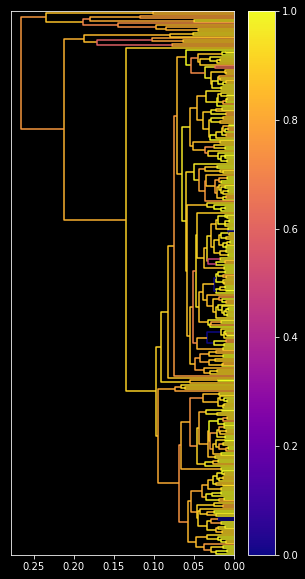

In [33]:
plot_dendrogram(linkage_shc,accuracy_matrix)

species generated
simulated compressed generated
accuracy matrix generated
plotting dendrogram


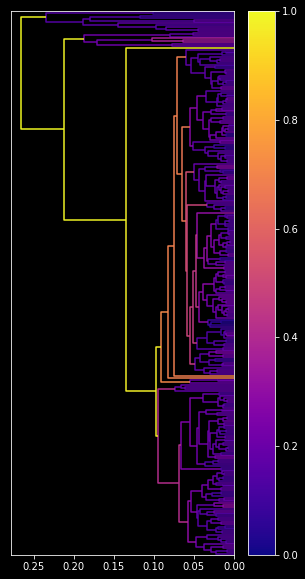

In [52]:
"""
knn Matrix
"""
CSC.sample = 0.3
CSC.nbits = 24
species = np.array(MM.loc[shared_genes])
print('species generated')
compressed = CSC.generate_compressed(species)
print('simulated compressed generated')
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
print('accuracy matrix generated')
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
print('plotting dendrogram')
plot_dendrogram(linkage_shc,accuracy)

random generated
simulated compressed generated
accuracy matrix generated
plotting dendrogram


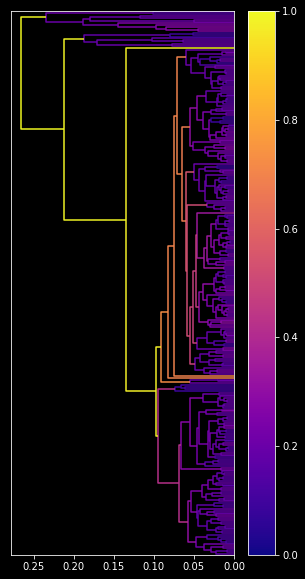

In [53]:
"""
Random Matrix
"""
CSC.sample = 0.3
CSC.nbits = 24
random_species = CSC.generate_random()
print('random generated')
random_compressed = CSC.generate_compressed(random_species)
print('simulated compressed generated')
random_accuracy_matrix = CSC.calculate_node_accuracy(random_compressed)
print('accuracy matrix generated')
random_accuracy_matrix_df = pd.DataFrame(random_accuracy_matrix,index=node_df.columns)
random_accuracy = np.array(random_accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
print('plotting dendrogram')
plot_dendrogram(linkage_shc,random_accuracy)

In [54]:
MM

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
X1110008P14Rik,1,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
X1500009L16Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1500011B03Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700001L19Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700019D03Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700037H04Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1700086L19Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X1810037I17Rik,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X2010300C02Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X2210013O21Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
len(np.unique(MM.index))

1220

In [60]:
len(set(list(MM.index)).intersection(list(filtered_genes)))

1203

In [55]:
filtered_counts.shape

(1220, 74967)

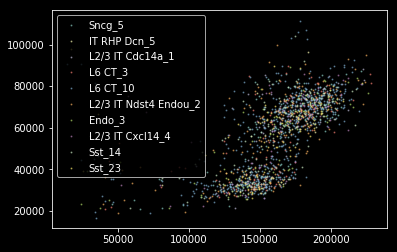

In [65]:
g1 = MM[MM[1]==1].index
g2 = MM[MM[2]==1].index
for ct in random.sample(good_types,10):
    ct_cells = list(metadata[metadata['cell_type_alias_label']==ct].index)
    ct_df = filtered_counts_df[ct_cells]
    plt.scatter(np.nansum(ct_df.loc[g1],axis=0),np.nansum(ct_df.loc[g2],axis=0),s=1,alpha=0.5,label=ct)
plt.legend()
plt.show()

In [75]:
np.max(MM,axis=1).sum()

504

In [77]:
MM.sum().sum()

2116

In [ ]:
"""
equal class dataset
Pos vs Neg weights 
LDA vs PCA
Gene prefiltering
Covariance vs variance (NB)
nbits
npos
index checking

"""

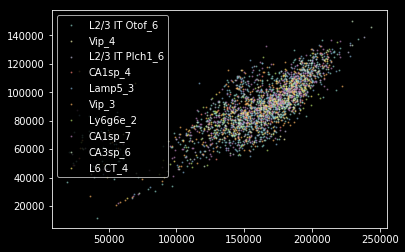

In [73]:
g1 = MM[MM[1]==1].index
g2 = MM[MM[7]==1].index
for ct in random.sample(good_types,10):
    ct_cells = list(metadata[metadata['cell_type_alias_label']==ct].index)
    ct_df = filtered_counts_df[ct_cells]
    plt.scatter(np.nansum(ct_df.loc[g1],axis=0),np.nansum(ct_df.loc[g2],axis=0),s=1,alpha=0.5,label=ct)
plt.legend()
plt.show()